# 0. Install and Import Dependencies

In [6]:
import os
import glob
import cv2 as cv
import mediapipe as mp
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report

# 1. Loading a Video and Saving Frames in Sequences

In [7]:
# Classes: 3 subfolders within 'Single_person_violent' => Kicking, Punching, Non-violent
CLASSES = ["Kicking", "Punching", "Standing"]

# We will define a fixed sequence length to handle variable-length videos
MAX_SEQ_LEN = 15 # example: 30 frames per video

# Set how many frames to skip when reading a video (to reduce computational load)
SKIP_RATE = 2  # example: capture 1 frame out of every 5

# 2. Extract Pose Sequence from a Single Video

This function opens a video file with OpenCV (cv.VideoCapture).

It skips frames by advancing the capture index so we only process 1 out of every SKIP_RATE frames.

For each processed frame, it uses MediaPipe Pose to detect 33 landmarks.

Each landmark has 4 values: (x, y, z, visibility), so for 33 landmarks, we get 132 values in one frame.

If no pose is detected, we append a zero vector (132 zeros).

Finally, it returns a NumPy array of shape (T, 132), where T is the number of frames we processed in the video.

In [8]:
def ensure_vertical_orientation(frame):
    height, width = frame.shape[:2]

    if width > height:
        # Rotate 90 degrees **clockwise** to make the frame portrait (not upside down)
        frame = cv.rotate(frame, cv.ROTATE_90_CLOCKWISE)
    
    return frame


In [9]:
def resize_frame(frame, target_width=720, target_height=1280):
    """
    Resize the frame to a fixed size while preserving aspect ratio
    and padding with black borders if needed.
    """
    original_h, original_w = frame.shape[:2]
    scale = min(target_width / original_w, target_height / original_h)
    new_w = int(original_w * scale)
    new_h = int(original_h * scale)

    resized = cv.resize(frame, (new_w, new_h))

    # Pad to target size (centered)
    top = (target_height - new_h) // 2
    bottom = target_height - new_h - top
    left = (target_width - new_w) // 2
    right = target_width - new_w - left

    padded = cv.copyMakeBorder(resized, top, bottom, left, right, cv.BORDER_CONSTANT, value=[0, 0, 0])
    return padded


In [10]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(
	min_detection_confidence=0.5,
	min_tracking_confidence=0.5,
	model_complexity=1
)

In [11]:
def get_pose_sequence_from_video(video_path, skip_rate=5, visualize=False):
	"""
	Opens a video, rotates to vertical if needed, resizes every frame
	to a fixed size, and returns a NumPy array of shape (num_frames, 132)
	containing (x, y, z, visibility) for 33 pose landmarks.
	"""
	cap = cv.VideoCapture(video_path)
	sequence = []

	with mp_pose.Pose(min_detection_confidence=0.5, 
						min_tracking_confidence=0.5) as pose_model:

		frame_index = 0
		while True:
			ret, frame = cap.read()
			if not ret:
				break
			
			frame = ensure_vertical_orientation(frame)
			frame = resize_frame(frame, target_width=720, target_height=1280)

			if frame_index % skip_rate == 0:
				rgb_frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
				results = pose_model.process(rgb_frame)

				if results.pose_landmarks:
					keypoints = []
					for lm in results.pose_landmarks.landmark:
						keypoints.extend([lm.x, lm.y, lm.z, lm.visibility])
					sequence.append(keypoints)
				else:
					sequence.append([0]*132)


			# ✅ Show frame for visual inspection
			if visualize:
				cv.imshow("Pose Frame (Press 'q' to quit)", frame)
				if cv.waitKey(10) & 0xFF == ord('q'):
					break
 
			frame_index += 1

	cap.release()
	return np.array(sequence)

In [49]:
# get_pose_sequence_from_video("Single_person_violent\Punching\punching1.mp4", skip_rate=SKIP_RATE, visualize=True)

## 3. Building the Full Dataset by Loop through all videos (X_sequences, y_labels)

We iterate over each subfolder (Kick, Punching, Non-violent) under Single_person_violent.

For each video, we call get_pose_sequence_from_video with our chosen SKIP_RATE.

We store the resulting array (T, 132) in a list, and store the string label (e.g. "Kick") in another list.

We will end up with X_sequences[i] as the 2D array of skeleton data, and y_labels[i] as the corresponding string label.

Note: At this point, X_sequences[i] might have different lengths because each video can have a different number of frames.

In [50]:
import glob # for file path matching

BASE_DIR = "Single_person_violent"  # your main dataset folder
X_sequences = []
y_labels = []

#? Loop through each class directory (e.g. "Kicking", "Punching", "Non-violent")
for cls in CLASSES:  # e.g. "Kick", "Punching", "Non-violent"
    class_dir = os.path.join(BASE_DIR, cls)
    
    #? Use glob to list all .mp4 or .avi files
    video_paths = glob.glob(os.path.join(class_dir, "*.mp4")) + glob.glob(os.path.join(class_dir, "*.avi"))
    
    print(video_paths)
    print(cls)

    #? For each video file in the class directory
    for vid_path in video_paths:
        seq = get_pose_sequence_from_video(vid_path, skip_rate=SKIP_RATE)
        
        # If the video has at least 1 frame successfully processed, append
        if seq.shape[0] > 0:
            X_sequences.append(seq)
            y_labels.append(cls)
        else:
            print(f"No frames extracted from {vid_path} (possibly empty or skip too high).")

['Single_person_violent\\Kicking\\kicking1.mp4', 'Single_person_violent\\Kicking\\kicking10.mp4', 'Single_person_violent\\Kicking\\kicking11.mp4', 'Single_person_violent\\Kicking\\kicking12.mp4', 'Single_person_violent\\Kicking\\kicking13.mp4', 'Single_person_violent\\Kicking\\kicking14.mp4', 'Single_person_violent\\Kicking\\kicking15.mp4', 'Single_person_violent\\Kicking\\kicking16.mp4', 'Single_person_violent\\Kicking\\kicking17.mp4', 'Single_person_violent\\Kicking\\kicking18.mp4', 'Single_person_violent\\Kicking\\kicking19.mp4', 'Single_person_violent\\Kicking\\kicking2.mp4', 'Single_person_violent\\Kicking\\kicking20.mp4', 'Single_person_violent\\Kicking\\kicking21.mp4', 'Single_person_violent\\Kicking\\kicking22.mp4', 'Single_person_violent\\Kicking\\kicking3.mp4', 'Single_person_violent\\Kicking\\kicking4.mp4', 'Single_person_violent\\Kicking\\kicking5.mp4', 'Single_person_violent\\Kicking\\kicking6.mp4', 'Single_person_violent\\Kicking\\kicking7.mp4', 'Single_person_violent\\Ki

### Save Preprocessed Data (`X_sequences` and `y_labels`) 

In [51]:
# Create output folder if it doesn't exist
SAVE_DIR = "extracted_data"
os.makedirs(SAVE_DIR, exist_ok=True)

# Convert to NumPy arrays and save
np.savez_compressed(
    os.path.join(SAVE_DIR, "pose_dataset_4.npz"),
    X=np.array(X_sequences, dtype=object),
    y=np.array(y_labels)
)

print(f"✅ Saved {len(X_sequences)} sequences to {SAVE_DIR}/pose_dataset.npz")

✅ Saved 90 sequences to extracted_data/pose_dataset.npz


### Load Preprocessed Data

In [54]:
data = np.load("extracted_data/pose_dataset_4.npz", allow_pickle=True)
X_sequences = list(data["X"])
y_labels = list(data["y"])

print(f"✅ Loaded {len(X_sequences)} sequences.")

✅ Loaded 90 sequences.


In [55]:
X_sequences[24].shape

(169, 132)

## 4. Pad or Truncate Sequences
LSTM/GRU networks expect uniform sequence lengths in a batch.

We define a function pad_or_truncate_sequence that ensures each sequence has exactly MAX_SEQ_LEN frames.

+ If a sequence is longer than MAX_SEQ_LEN, we take the first MAX_SEQ_LEN frames.

+ If it’s shorter, we pad with zeros at the end.

### Sequence Standardization 
Videos inherently vary in length, resulting in sequences of different frame counts. To address this variability, sequences are standardized to a fixed length defined by `MAX_SEQ_LEN`. Shorter sequences are padded with zeros, while longer sequences are truncated, ensuring uniform input dimensions for the Deep Neural Network.
    

In [ ]:
STRIDE = 1

In [57]:
# def segment_sequence(sequence, max_seq_len=MAX_SEQ_LEN, stride=STRIDE):
#     """
#     Breaks a long pose sequence into overlapping sub-sequences (segments)
#     using a sliding window of fixed length and stride.
    
#     Returns:
#         segments: np.array of shape (num_segments, max_seq_len, 132)
#     """
#     segments = []
#     for i in range(0, len(sequence) - max_seq_len + 1, stride):
#         segment = sequence[i:i+max_seq_len]
#         segments.append(segment)
    
#     return np.array(segments)


In [ ]:
import numpy as np

def segment_sequence_with_tail(seq, max_seq_len=5, stride=2):
    """
    Breaks a long pose sequence into fixed‑length segments:
      1) All full windows of length max_seq_len, stepping by stride
      2) One final 'leftover' segment (the tail), padded to max_seq_len
    If seq is shorter than max_seq_len, returns one padded segment.
    Returns an array of shape (n_segments, max_seq_len, n_features).
    """
    segments = []
    L = len(seq) 

    # 1) Full windows
    for i in range(0, L - max_seq_len + 1, stride):
        segments.append(seq[i : i + max_seq_len])

    # 2) Tail leftover
    if L > max_seq_len:
        # compute where the next window would start
        last_full_start = ((L - max_seq_len) // stride) * stride
        next_start = last_full_start + stride
        if next_start < L:
            tail = seq[next_start:]
            # pad tail up to max_seq_len
            pad_amt = max_seq_len - tail.shape[0]
            tail_padded = np.vstack([
                tail,
                np.zeros((pad_amt, seq.shape[1]), dtype=seq.dtype)
            ])
            segments.append(tail_padded)
    else:
        # seq is shorter than max_seq_len: pad entire seq once
        pad_amt = max_seq_len - L
        padded = np.vstack([
            seq,
            np.zeros((pad_amt, seq.shape[1]), dtype=seq.dtype)
        ])
        segments = [padded]

    return np.array(segments)


In [59]:
def pad_or_truncate_sequence(seq, max_len=MAX_SEQ_LEN):
    """
    seq: (T, 132) array for T frames
    Returns an array of shape (max_len, 132).
    """
    
    length = seq.shape[0]
    num_features = seq.shape[1]
    
    # print(length, num_features)
    
    if length > max_len:
        # Truncate
        return seq[:max_len, :]
    else:
        # Pad with zeros
        padded = np.zeros((max_len, num_features))
        padded[:length, :] = seq
        return padded

### Examine Video Sequence
+ Sampled frames = ⌈5 frames ÷ 1⌉ = 5 frames
+ Number of segments = (5 – 2) / 1 + 1 = 3 + 1 = 4

Those four segments correspond to frame‑index windows:

+   Segment 1: frames [0, 1]
+   Segment 2: frames [1, 2]
+   Segment 3: frames [2, 3]
+   Segment 4: frames [3, 4]

In [83]:
import cv2

def count_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return total

def count_sequences(video_path, skip_rate=SKIP_RATE, max_seq_len=MAX_SEQ_LEN, stride=STRIDE):
    # Assumes get_pose_sequence_from_video and segment_sequence are in scope
    pose_seq = get_pose_sequence_from_video(video_path, skip_rate=skip_rate)
    segments = segment_sequence_with_tail(pose_seq, max_seq_len=max_seq_len, stride=stride)
    return len(segments)

# Example:
# video_path = "Single_person_violent/Kicking/kicking24.mp4"
video_path = "Single_person_violent/Punching/punching36.mp4"
n_frames = count_frames(video_path)
n_seqs   = count_sequences(video_path, skip_rate=SKIP_RATE, max_seq_len=MAX_SEQ_LEN, stride=STRIDE)

print(f"Video: {video_path}")
print(f"  • Total frames  : {n_frames}")
print(f"  • Total segments: {n_seqs}")


Video: Single_person_violent/Punching/punching36.mp4
  • Total frames  : 517
  • Total segments: 124


In [62]:
# Calculate average sequence length from X_sequences
seq_lengths = [seq.shape[0] for seq in X_sequences]
# Convert sequence lengths to a DataFrame
df_seq_lengths = pd.DataFrame(seq_lengths, columns=['Sequence_Length'])

# Get statistical description
print("Sequence Length Statistics:")
df_seq_lengths.describe()

Sequence Length Statistics:


,Sequence_Length
count,90.000000
mean,41.744444
std,45.320224
min,1.000000
25%,17.000000
50%,28.000000
75%,41.750000
max,259.000000


In [82]:
X_seq_padded = []
y_seq_labels = []

for seq, label in zip(X_sequences, y_labels):
    # get _all_ segments including the leftover tail
    segs = segment_sequence_with_tail(
        seq,
        max_seq_len=MAX_SEQ_LEN,
        stride=1
    )
    for s in segs:
        X_seq_padded.append(s)
        y_seq_labels.append(label)

# X_seq_padded = np.array(X_seq_padded)    # shape (total_segments, MAX_SEQ_LEN, n_features)
# y_seq_labels = np.array(y_seq_labels)    # shape (total_segments,)

X_seq_padded = np.array(X_seq_padded, dtype=np.float32)
y_seq_labels = np.array(LabelEncoder().fit_transform(y_seq_labels), dtype=np.int32)

print("Final X shape:", X_seq_padded.shape)      # (n_segments, MAX_SEQ_LEN, 132)
print("Final y shape:", y_seq_labels.shape)      # (n_segments,)


Final X shape: (2663, 15, 132)
Final y shape: (2663,)


Write to CSV file for visualization and analysis

## 5. Encode Labels and Split Data

We use LabelEncoder to convert "Kicking", "Punching", "Non-violent" into numeric IDs: e.g. 0, 1, 2.

Then we split into train/test sets (e.g., 80/20) for fair evaluation.

We store them as X_train, X_test, y_train, y_test.

In [64]:
label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(y_seq_labels)  
# e.g. "Kick"->0, "Punching"->2, "Standing"->1 (the mapping depends on alphabetical order)

# Convert to NumPy
y_int = np.array(y_int)
print(y_int.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_seq_padded, 
    y_int, 
    test_size=0.2, 
    stratify=y_int,  # keep classes balanced
    random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train labels shape:", y_train.shape, "Test labels shape:", y_test.shape)

(1394,)
Train shape: (1115, 15, 132) Test shape: (279, 15, 132)
Train labels shape: (1115,) Test labels shape: (279,)


## 6. Train and Evaluate Machine Learning Classification Model 

We create a sequential Keras model with an LSTM layer (64 units) returning sequences, followed by another LSTM (32 units), then a Dense layer for classification.

Use sparse_categorical_crossentropy since we have integer labels (0, 1, 2).

num_classes is the length of label_encoder.classes_.

In [65]:
N, MAX_SEQ_LEN, NUM_FEATURES = X_seq_padded.shape
NUM_CLASSES = len(np.unique(y_int))

PATIENCE = 8
EPOCH = 20
BATCH_SIZE = 8

print("N:", N, "\nMAX_SEQ_LEN:", MAX_SEQ_LEN, "\nNUM_FEATURES:", NUM_FEATURES, "\nnum_classes:", NUM_CLASSES)

N: 1394 
MAX_SEQ_LEN: 15 
NUM_FEATURES: 132 
num_classes: 3


### 6.1 Build Model & Hypermeters Tunining

### 6.1 Build and Train LSTM Model

**Dropout:** Applied to the non-recurrent connections within a layer. This means it randomly drops neurons (and their connections) during the forward pass in the current time step.
+ Applies to the input connections going into the LSTM/GRU cell.
+ At each time step t, some input features are randomly "dropped" (set to zero) with probability dropout.
+ Helps prevent overfitting from relying too heavily on specific input features.

**Recurrent Dropout:** Applied to the recurrent connections within a recurrent layer (like LSTM or GRU). This means it randomly drops connections between the recurrent units across time steps. 
+ Applies to the recurrent connections (i.e., the hidden state passed between time steps). 
+ At each time step t, some units in the hidden state are randomly dropped before being passed to the next time step.
+ Helps prevent overfitting by regularizing how much the network can memorize across time steps.

In [66]:
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential

In [67]:
def build_lstm_model(
	max_seq_len=MAX_SEQ_LEN, 
	num_features=NUM_FEATURES, 
	num_classes=NUM_CLASSES,
	dropout_rate=0.4, 
	recurrent_dropout_rate=0.4,
 	l2_reg=1e-4
):
	model = tf.keras.Sequential([
		layers.Input(shape=(max_seq_len, num_features)),
		layers.LSTM(64, return_sequences=True, 
				   dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate,
				   kernel_regularizer=regularizers.l2(l2_reg)),

		layers.LSTM(32, 
				   dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate,
				   kernel_regularizer=regularizers.l2(l2_reg)),
		
		layers.Dense(64, 
					activation='relu', 
					kernel_regularizer=regularizers.l2(l2_reg)),
		
  		layers.Dropout(0.5),
		layers.Dense(num_classes, activation='softmax')
	])
	model.compile(
		optimizer='adam',
		loss='sparse_categorical_crossentropy',
		metrics=['accuracy']
	)
	return model

In [68]:
build_lstm_model().summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 15, 64)         │        50,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,155 (254.51 KB)

 Trainable params: 65,155 (254.51 KB)

 Non-trainable params: 0 (0.00 B)

### 6.2. Build and Train GRU Model
Similar to LSTM but we replace layers.LSTM with layers.GRU.

In [69]:
def build_gru_model(
    max_seq_len=MAX_SEQ_LEN, 
    num_features=NUM_FEATURES, 
    num_classes=NUM_CLASSES,
    dropout_rate=0.4, 
    recurrent_dropout_rate=0.4,
	l2_reg=1e-4	
):
    model = tf.keras.Sequential([
        layers.Input(shape=(max_seq_len, num_features)),
        
        layers.GRU(
            		64, return_sequences=True, 
					dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate,
        			kernel_regularizer=regularizers.l2(l2_reg)),
        layers.GRU(
            		32, 
					dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate,
					kernel_regularizer=regularizers.l2(l2_reg)),
       
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

build_gru_model().summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_8 (GRU)                     │ (None, 15, 64)         │        38,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_9 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,523 (185.64 KB)

 Trainable params: 47,523 (185.64 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
# And a model function (like the build_lstm_model above).
# results_gru = kfold_validation(save_model_path="gru_model.h5", model_fn=build_gru_model, epochs=20)
# This prints out each fold's accuracy, confusion matrix, classification report
# Then returns a dictionary with the final cross-validation results.


### 6.3. Build and Train DNN Model (Flattened Sequence)

In [71]:
def build_dnn_model(input_dims, num_classes=NUM_CLASSES, dropout_rates=(0.3, 0.2), l2_reg=1e-4):
    """
    Returns a freshly compiled DNN model that exut_dim`.
    The model outputs `num_classes` with 'softmax' for multi-class classification. 
    The `input_dim` is the number of features in the input data.
	The `num_classes` is the number of classes for classification.
    
    dropout_rates is a tuple indicating the dropout after each Dense layer.
    Example: (0.3, 0.2) => 30% dropout after first layer, 20% after second layer.
    """

    model = tf.keras.Sequential([
        layers.Input(shape=(input_dims,)),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dropout(dropout_rates[0]),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dropout(dropout_rates[1]),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [72]:
input_dim = X_train.shape[1]
print("Input dimension:", input_dim)
build_dnn_model(input_dim).summary()

Input dimension: 15


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 128)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,499 (41.01 KB)

 Trainable params: 10,499 (41.01 KB)

 Non-trainable params: 0 (0.00 B)

# 7. Evaluation and Comparison
After training, we evaluate each model on the test set.

For LSTM/GRU, we can feed X_test in its (N, 30, 132) shape.

For DNN, we feed the flattened X_test_dnn.

Note: Compare before and after dropout

In [73]:
param_grid = {'dropout_rate': [0.3, 0.4, 0.5]}
grid = list(ParameterGrid(param_grid))

In [74]:
from tqdm import tqdm

In [75]:
# 1) Pre‑flatten for DNN once
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat  = X_test.reshape((X_test.shape[0], -1))

# 2) Parameter grid
dropouts = [0.3, 0.4, 0.5]
grid     = ParameterGrid({'dropout_rate': dropouts})

# 3) Map each model type to its builder and input dims
builders = {
    'lstm': (build_lstm_model, (MAX_SEQ_LEN, NUM_FEATURES, NUM_CLASSES)),
    'gru':  (build_gru_model,  (MAX_SEQ_LEN, NUM_FEATURES, NUM_CLASSES)),
    'dnn':  (build_dnn_model,  (X_train_flat.shape[1], NUM_CLASSES))
}

results = []

In [77]:

#? 4) Grid search with a single fit() per model
for model_type, (builder, dims) in builders.items():
	for p in tqdm(grid, desc=f'{model_type} grid', leave=False):
		dr = p['dropout_rate']
		
		# Instantiate model
		if model_type in ('lstm', 'gru'):
			model = builder(
				*dims,
				dropout_rate=dr,
				recurrent_dropout_rate=dr
			)
			Xtr, Xte = X_train, X_test
			ytr, yte = y_train, y_test
		else:  # dnn
			model = builder(
				*dims,
				dropout_rates=(dr, dr)
			)
			Xtr, Xte = X_train_flat, X_test_flat
			ytr, yte = y_train, y_test
		
		# Train once with validation_data
		hist = model.fit(
			Xtr, ytr,
			validation_data=(Xte, yte),
			epochs=5,
			batch_size=8,
			verbose=0
		)
		
		# Extract final accuracies
		train_acc = hist.history['accuracy'][-1]
		test_acc  = hist.history['val_accuracy'][-1]
		
		# Save the trained model to .h5 for later inference
		filename = f"model_weights\{model_type}_dr{int(dr*100)}.keras"
		model.save(filename)
		
		results.append({
			'model':        model_type,
			'dropout_rate': dr,
			'train_acc':    train_acc,
			'test_acc':     test_acc,
			'saved_file':   filename
		})

In [78]:
# Summarize
df = pd.DataFrame(results)
print(df)

  model  dropout_rate  train_acc  test_acc                     saved_file
0  lstm           0.3   0.711211  0.792115  model_weights\lstm_dr30.keras
1  lstm           0.4   0.647534  0.745520  model_weights\lstm_dr40.keras
2  lstm           0.5   0.586547  0.670251  model_weights\lstm_dr50.keras
3   gru           0.3   0.750673  0.835125   model_weights\gru_dr30.keras
4   gru           0.4   0.684305  0.831541   model_weights\gru_dr40.keras
5   gru           0.5   0.605381  0.720430   model_weights\gru_dr50.keras
6   dnn           0.3   0.746188  0.870968   model_weights\dnn_dr30.keras
7   dnn           0.4   0.632287  0.795699   model_weights\dnn_dr40.keras
8   dnn           0.5   0.568610  0.781362   model_weights\dnn_dr50.keras


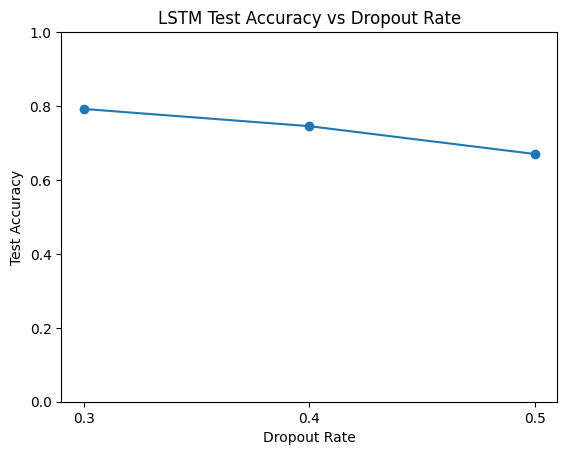

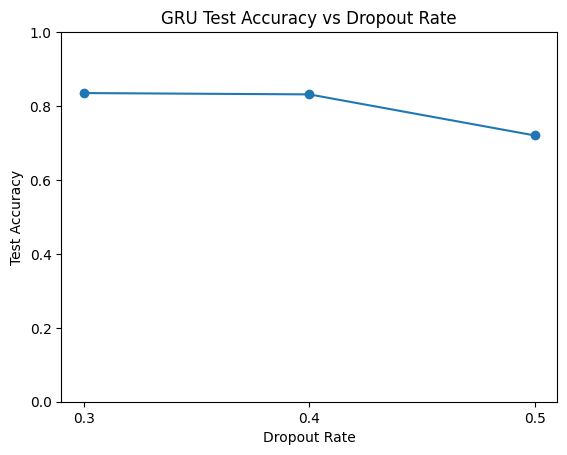

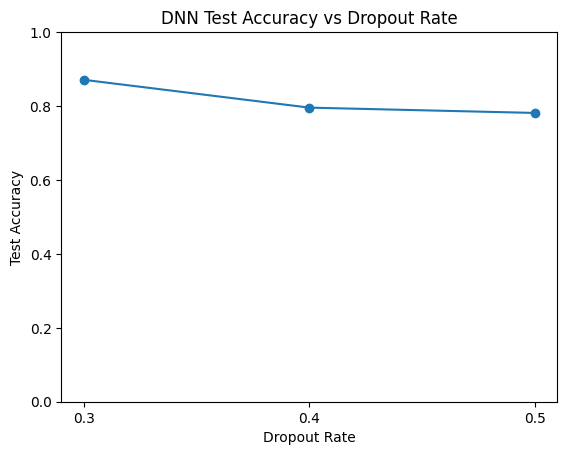

In [79]:
# Plot Test Accuracy vs. Dropout Rate
for model_type in df['model'].unique():
    subset = df[df['model'] == model_type]
    plt.figure()
    plt.plot(subset['dropout_rate'], subset['test_acc'], marker='o')
    plt.title(f'{model_type.upper()} Test Accuracy vs Dropout Rate')
    plt.xlabel('Dropout Rate')
    plt.ylabel('Test Accuracy')
    plt.xticks(subset['dropout_rate'])
    plt.ylim(0, 1.0)
    plt.show()

# 5. Make Detection

In [12]:
import cv2 as cv
import numpy as np
import collections
import tensorflow as tf
import mediapipe as mp

# 1) Define constants (must match your training setup)
MAX_SEQ_LEN   = 15
NUM_FEATURES  = 33 * 4   # 33 landmarks × (x,y,z,visibility)
CLASSES = ["Kicking", "Punching", "Standing"]
VIS_THRESH     = 0.3      # visibility threshold
PUNCH_SPEED_T  = 0.1     # normalized‐coords/frame threshold for punching
KICK_SPEED_T   = 0.1     # normalized‐coords/frame threshold for kicking

# 2) Load your trained models
lstm_model = tf.keras.models.load_model("model_weights/lstm_dr50.keras")
gru_model  = tf.keras.models.load_model("model_weights/gru_dr50.keras")
dnn_model  = tf.keras.models.load_model("model_weights/dnn_dr50.keras")

# Pick which to use:
infer_model = lstm_model  # or gru_model, or dnn_model

In [13]:
# Landmark indices
WRISTS = [
    mp.solutions.pose.PoseLandmark.LEFT_WRIST.value,
    mp.solutions.pose.PoseLandmark.RIGHT_WRIST.value
]
KNEES  = [
    mp.solutions.pose.PoseLandmark.LEFT_KNEE.value,
    mp.solutions.pose.PoseLandmark.RIGHT_KNEE.value
]
ANKLES = [
    mp.solutions.pose.PoseLandmark.LEFT_ANKLE.value,
    mp.solutions.pose.PoseLandmark.RIGHT_ANKLE.value
]

In [ ]:
# Helper to compute max 2D speed in a buffer for given landmark indices
def max_landmark_speed(buffer, landmark_idxs):
    """
    buffer: deque of length MAX_SEQ_LEN, each element is flat [x1,y1,z1,vis1,...]
    
    xi, yi: is in the range [0 … 1], where 1.0 means “100% of the frame width” (for x) 
			or “100% of the frame height” (for y).
    
    landmark_idxs: list of landmark indices to check (0-based 0–32)
    returns: max Euclidean speed (in normalized coords per frame)
    """
    seq = np.array(buffer, dtype=np.float32)  # shape (T, 132)
    # extract only x,y coords for our landmarks
    speeds = []
    for lm in landmark_idxs:
        #? xi, yi is the normalized‐coordinate units per frame, 
        #? 
        xi = seq[:, lm*4 + 0]  # x
        yi = seq[:, lm*4 + 1]  # y
        # compute displacements between successive frames
        dx = np.diff(xi)
        dy = np.diff(yi)
        dist = np.sqrt(dx*dx + dy*dy)  # length T-1
        speeds.append(dist)
    # stack all speeds and return the overall max
    if speeds:
        return float(np.max(np.stack(speeds)))
    else:
        return 0.0

In [15]:
# Helper to compute max 2D speed in a buffer for given landmark indices
def max_landmark_speed(buffer, landmark_idxs):
    """
    buffer: deque of length MAX_SEQ_LEN, each element is flat [x1,y1,z1,vis1,...]
    landmark_idxs: list of landmark indices to check (0-based 0–32)
    returns: max Euclidean speed (in normalized coords per frame)
    """
    seq = np.array(buffer, dtype=np.float32)  # shape (T, 132)
    # extract only x,y coords for our landmarks
    speeds = []
    for lm in landmark_idxs:
        xi = seq[:, lm*4 + 0]  # x
        yi = seq[:, lm*4 + 1]  # y
        # compute displacements between successive frames
        dx = np.diff(xi)
        dy = np.diff(yi)
        dist = np.sqrt(dx*dx + dy*dy)  # length T-1
        speeds.append(dist)
    # stack all speeds and return the overall max
    if speeds:
        return float(np.max(np.stack(speeds)))
    else:
        return 0.0

In [16]:
# === MediaPipe setup ===
mp_pose = mp.solutions.pose
pose    = mp_pose.Pose(min_detection_confidence=0.5,
                       min_tracking_confidence=0.5)

# === Rolling buffer ===
buffer = collections.deque(maxlen=MAX_SEQ_LEN)

# === Webcam ===
cap = cv.VideoCapture(0)
cap.set(cv.CAP_PROP_FRAME_WIDTH,  960)
cap.set(cv.CAP_PROP_FRAME_HEIGHT, 720)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv.resize(frame, (960, 720))
    rgb     = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    results = pose.process(rgb)

    # 1) Extract keypoints or zeros
    if results.pose_landmarks:
        keypoints = []
        for lm in results.pose_landmarks.landmark:
            keypoints.extend([lm.x, lm.y, lm.z, lm.visibility])
    else:
        keypoints = [0.0] * NUM_FEATURES

    buffer.append(keypoints)

    # Default label
    label = "Warming up..."

    # 2) When we have enough frames, do conditional + model inference
    if len(buffer) == MAX_SEQ_LEN:
        # Check visibility of WRISTS/ANKLES first
        has_limbs = False
        if results.pose_landmarks:
            for idx in WRISTS + ANKLES:
                if results.pose_landmarks.landmark[idx].visibility >= VIS_THRESH:
                    has_limbs = True
                    break

        if not has_limbs:
            # No hands/feet visible → Non‑violent
            class_name, confidence = "Non‑violent", 100.0
        else:
            # Run your model
            seq = np.array(buffer, dtype=np.float32)
            if infer_model.input_shape[-1] == seq.size:
                seq_input = seq.reshape(1, -1)
            else:
                seq_input = seq[np.newaxis, ...]
            preds      = infer_model.predict(seq_input, verbose=0)[0]
            class_id   = int(np.argmax(preds))
            confidence = float(preds[class_id] * 100)
            class_name = CLASSES[class_id]

            # 3) Motion‐speed check override
            if class_name == "Punching":
                speed = max_landmark_speed(buffer, WRISTS)
                if speed < PUNCH_SPEED_T:
                    class_name, confidence = "Non‑violent", 100.0
            elif class_name == "Kicking":
                # check both knees and ankles
                speed_knee  = max_landmark_speed(buffer, KNEES)
                speed_ankle = max_landmark_speed(buffer, ANKLES)
                if max(speed_knee, speed_ankle) < KICK_SPEED_T:
                    class_name, confidence = "Non‑violent", 100.0

        label = f"{class_name} ({confidence:.1f}%)"

    # 4) Draw
    cv.putText(frame, label, (30, 50),	
               cv.FONT_HERSHEY_SIMPLEX, 1.2, (0,255,0), 3)
    if results.pose_landmarks:
        mp.solutions.drawing_utils.draw_landmarks(
            frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp.solutions.drawing_utils.DrawingSpec((245,117,66),2,2),
            connection_drawing_spec=mp.solutions.drawing_utils.DrawingSpec((245,66,230),2,2)
        )

    cv.imshow("Live Action Detection", frame)
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv.destroyAllWindows()
pose.close()





### Test on Video

In [ ]:
# Use the test_video_paths that's already defined in the context
# test_video_path = "Single_person_violent\Punching\punching1.mp4"
test_video_path = "Single_person_violent\Standing\\video_0_flip.avi"
print(f"Processing: {os.path.basename(test_video_path)}")

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(
	min_detection_confidence=0.5,
	min_tracking_confidence=0.5,
	model_complexity=1
)

# Open video file
cap = cv.VideoCapture(test_video_path)

# Buffer to store latest MAX_SEQ_LEN frames of keypoints
buffer = collections.deque(maxlen=MAX_SEQ_LEN)

while True:
	ret, frame = cap.read()
	if not ret:
		break

	# ✅ Step 1: Rotate landscape to vertical
	frame = ensure_vertical_orientation(frame)

	# ✅ Step 2: Resize to 720x1280 for consistency
	frame = resize_frame(frame, target_width=720, target_height=1280)

	# Convert to RGB and get pose
	rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
	results = pose.process(rgb)

	# Extract pose keypoints
	if results.pose_landmarks:
		keypoints = []
		for lm in results.pose_landmarks.landmark:
			keypoints.extend([lm.x, lm.y, lm.z, lm.visibility])
	else:
		keypoints = [0] * NUM_FEATURES

	# Add keypoints to buffer
	buffer.append(keypoints)

	if len(buffer) == MAX_SEQ_LEN:
		seq = np.array(buffer)

		if infer_model == dnn_infer_model:
			seq_input = seq.reshape(1, -1)  # DNN input shape: (1, 660)
		else:
			seq_input = np.expand_dims(seq, axis=0)  # LSTM/GRU input shape: (1, 5, 132)

		pred = infer_model.predict(seq_input, verbose=0)
		class_id = np.argmax(pred)
		confidence = float(pred[0][class_id]) * 100
		class_name = CLASSES[class_id]

		if class_name == "Standing":
			display_text = f"{class_name} ({confidence:.1f}%), Non-Violent"
		else:
			display_text = f"{class_name} ({confidence:.1f}%), Violent"

		# Show prediction on frame
		cv.putText(frame, f'Action: {display_text}', (30, 50),
				   cv.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

	# Draw pose landmarks
	if results.pose_landmarks:
		mp.solutions.drawing_utils.draw_landmarks(
			frame,
			results.pose_landmarks,
			mp_pose.POSE_CONNECTIONS,
			landmark_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
			connection_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
		)

	# Display the frame
	cv.imshow(f"Action Detection - {os.path.basename(test_video_path)}", frame)

	# Press 'q' to exit
	if cv.waitKey(1) & 0xFF == ord('q'):
		break

# Cleanup
cap.release()
cv.destroyAllWindows()
pose.close()
